#####
1. Minimise Vol (Scipy Optimise)***
2. Minimise Calmar (Drawdown) (Scipy Optimise)***
3. Minimise Neg sharpe (Scipy Optimise)
4. Momentum Strategy (Simple)***
5. Neural Network (LSTM Model)
6. Hierarchial Risk Parity 
7.



In [2]:
from quant_risk.statistics import financial_ratios as ratios
from quant_risk.portfolio import portfolio as port
from quant_risk.portfolio.portfolio import MeanVariance
from quant_risk.utils import plot
from quant_risk.utils import fetch_data as fetch_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import functions as f
%load_ext autoreload
%autoreload 2

In [3]:
tickerlist = ['^STI','^GSPC','^RUT','^DJI','^IXIC','^FTSE','^HSI','^NSEI','^VIX','^N225','^KS11','GLD','SHY','TLH','TLT']

In [4]:
df = yf.download(tickerlist, period = '1d', start = '2007-01-01',end = pd.Timestamp.today())
columns = df.columns
df = df.iloc[:,:15]['2007':]
price_change = df.pct_change().fillna(method = 'bfill')
df.columns = [['Gold','2 Year Bond','10-20 year Bond','20 Year Bond','Dow','FTSE','S&P500','HSI','Nasdaq','Kospi','Nikkei','Nifty','Russell2k','STI','Vix']]
df

[*********************100%***********************]  15 of 15 completed


,Gold,2 Year Bond,10-20 year Bond,20 Year Bond,Dow,FTSE,S&P500,HSI,Nasdaq,Kospi,Nikkei,Nifty,Russell2k,STI,Vix
Date,,,,,,,,,,,,,,,
2007-01-02,NaN,NaN,NaN,NaN,NaN,6310.899902,NaN,20310.179688,NaN,1435.260010,NaN,NaN,NaN,NaN,NaN
2007-01-03,62.279999,65.291283,NaN,56.795158,12474.519531,6319.000000,1416.599976,20413.390625,2423.159912,1409.349976,NaN,NaN,787.419983,3037.739990,12.040000
2007-01-04,61.650002,65.356529,NaN,57.139507,12480.690430,6287.000000,1418.339966,20025.580078,2453.429932,1397.290039,17353.669922,NaN,789.950012,3023.800049,11.510000
2007-01-05,60.169998,65.315712,NaN,56.890823,12398.009766,6220.100098,1409.709961,20211.279297,2434.250000,1385.760010,17091.589844,NaN,775.869995,3029.040039,12.140000
2007-01-08,60.480000,65.274948,NaN,56.992855,12423.490234,6194.200195,1412.839966,20029.660156,2438.199951,1370.810059,NaN,NaN,776.989990,3000.000000,12.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,177.050003,83.010002,125.370003,121.190002,34049.460938,7380.500000,4296.120117,19869.339844,13004.849609,2657.129883,26590.779297,16953.949219,1954.199951,3339.590088,27.020000
2022-04-26,177.320007,83.160004,126.599998,122.410004,33240.179688,7386.200195,4175.200195,19934.710938,12490.740234,2668.310059,26700.109375,17200.800781,1890.469971,3322.050049,33.520000
2022-04-27,175.979996,83.120003,125.349998,120.839996,33301.929688,7425.600098,4183.959961,19946.359375,12488.929688,2639.060059,26386.630859,17038.400391,1884.040039,3320.669922,31.600000


In [5]:
#Take a look at the price change dataframe
tickerlist.sort()
price_change.columns = tickerlist
price_change.head(2)

,GLD,SHY,TLH,TLT,^DJI,^FTSE,^GSPC,^HSI,^IXIC,^KS11,^N225,^NSEI,^RUT,^STI,^VIX
Date,,,,,,,,,,,,,,,
2007-01-02,-0.010116,0.000999,-0.00498,0.006063,0.000495,0.001284,0.001228,0.005082,0.012492,-0.018053,-0.015102,0.011469,0.003213,-0.004589,-0.04402
2007-01-03,-0.010116,0.000999,-0.00498,0.006063,0.000495,0.001284,0.001228,0.005082,0.012492,-0.018053,-0.015102,0.011469,0.003213,-0.004589,-0.04402


## Look at a sample BETA of STI index with respect to S&P 500 using Linear Regression

In [6]:
x = np.array(price_change['^STI']).reshape((-1,1))
y = np.array(price_change['^GSPC'])
model = LinearRegression().fit(x, y)
# Prints the beta to the screen 
print('Beta: ', model.coef_)
#Beta = 0.3264

Beta:  [0.32642251]


In [7]:
x = np.array(price_change['^GSPC']).reshape((-1,1))
y = np.array(price_change['^GSPC'])
model = LinearRegression().fit(x, y)
# Prints the beta to the screen 
print('Beta: ', model.coef_)
#S&P500 has a beta of 1

Beta:  [1.]


# Plot Out the Efficient Frontier
1. For this step we will plot the efficient frontier to see which is the best portfolio that will give us the Global Minimum Variance Portfolio
2. This step employs a trial and error process to iteratively add small increments to our target return in the Markowitz efficient frontier
3. Observe where on the efficient frontier does the point land on

In [76]:
num_r = 15
r_bar = np.array([i for i in range(num_r)])*0.003+0.002
r_bar


array([0.002, 0.005, 0.008, 0.011, 0.014, 0.017, 0.02 , 0.023, 0.026,
       0.029, 0.032, 0.035, 0.038, 0.041, 0.044])

In [89]:
ann_ret = ratios.annualised_returns(df.fillna(method = 'bfill').pct_change(),250) #annualised returns, period = 250 as we are using daily data and there are about 250 trading days
ann_cov = df.pct_change().fillna(method = 'bfill').cov() #Covariance Matrix
port_ret_list = []
port_var_list = []
for i in range(len(r_bar)):
    r = r_bar[i]
    sol = f.minimise_volatility_full(r,ann_ret,ann_cov)
    if sol['success'] == True:
        port_ret_list.append(f.pf_returns(sol.x,df))
        port_var_list.append(f.portfolio_variance(sol.x,ann_cov))

port_vol = np.asarray(port_var_list)
port_vol.sort()
port_return = np.asarray(port_ret_list)

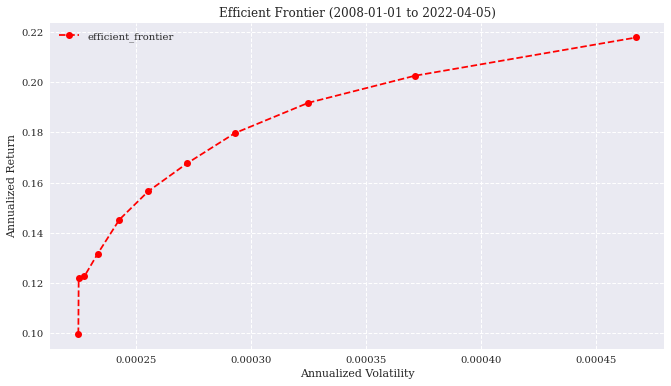

In [97]:
# Plotting efficient frontier
plt.rcParams['figure.figsize'] = (11, 6)
plt.plot(port_vol/14.4, port_return**1/14.4, 'ro--', label='efficient_frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True, linestyle='--')
plt.legend()
plt.title('Efficient Frontier (2008-01-01 to 2022-04-05)')

plt.show()


## Next we apply the GMV iteratively to backtest the Minimum Variance Portfolio Strategy

In [96]:
df['2008-01-01':]

,Gold,2 Year Bond,10-20 year Bond,20 Year Bond,Dow,FTSE,S&P500,HSI,Nasdaq,Kospi,Nikkei,Nifty,Russell2k,STI,Vix
Date,,,,,,,,,,,,,,,
2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6144.350098,NaN,NaN,NaN
2008-01-02,84.860001,70.149643,74.257652,63.100193,13043.959961,6416.700195,1447.160034,27560.519531,2609.629883,1853.449951,NaN,6179.399902,753.549988,3461.219971,23.170000
2008-01-03,85.570000,70.260361,74.229668,63.013268,13056.719727,6479.399902,1447.160034,26887.279297,2602.679932,1852.729980,NaN,6178.549805,745.010010,3397.060059,22.490000
2008-01-04,85.129997,70.362587,74.362633,63.026653,12800.179688,6348.500000,1411.630005,27519.689453,2504.649902,1863.900024,14691.410156,6274.299805,721.599976,3437.790039,23.940001
2008-01-07,84.769997,70.319984,74.572472,63.300781,12827.490234,6335.700195,1416.180054,27179.490234,2499.459961,1831.140015,14500.549805,6279.100098,723.950012,3353.060059,23.790001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,177.050003,83.010002,125.370003,121.190002,34049.460938,7380.500000,4296.120117,19869.339844,13004.849609,2657.129883,26590.779297,16953.949219,1954.199951,3339.590088,27.020000
2022-04-26,177.320007,83.160004,126.599998,122.410004,33240.179688,7386.200195,4175.200195,19934.710938,12490.740234,2668.310059,26700.109375,17200.800781,1890.469971,3322.050049,33.520000
2022-04-27,175.979996,83.120003,125.349998,120.839996,33301.929688,7425.600098,4183.959961,19946.359375,12488.929688,2639.060059,26386.630859,17038.400391,1884.040039,3320.669922,31.600000


## Get our returns dataframe which shows the daily returns instead of closing price for each asset

In [112]:
returns = (df-df.shift(1))/df.shift(1)
returns

,Gold,2 Year Bond,10-20 year Bond,20 Year Bond,Dow,FTSE,S&P500,HSI,Nasdaq,Kospi,Nikkei,Nifty,Russell2k,STI,Vix
Date,,,,,,,,,,,,,,,
2007-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-03,NaN,NaN,NaN,NaN,NaN,0.001284,NaN,0.005082,NaN,-0.018053,NaN,NaN,NaN,NaN,NaN
2007-01-04,-0.010116,0.001000,NaN,0.006064,0.000495,-0.005064,0.001228,-0.018998,0.012492,-0.008557,NaN,NaN,0.003213,-0.004589,-0.044020
2007-01-05,-0.024007,-0.000623,NaN,-0.004352,-0.006625,-0.010641,-0.006085,0.009273,-0.007818,-0.008252,-0.015102,NaN,-0.017824,0.001733,0.054735
2007-01-08,0.005152,-0.000624,NaN,0.001794,0.002055,-0.004164,0.002220,-0.008986,0.001623,-0.010788,NaN,NaN,0.001444,-0.009587,-0.011532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,-0.017971,0.001569,0.007716,0.010001,0.007041,-0.018772,0.005698,-0.037269,0.012895,-0.017592,-0.018981,-0.012695,0.006977,-0.006403,-0.042184
2022-04-26,0.001525,0.001807,0.009811,0.010067,-0.023768,0.000772,-0.028146,0.003290,-0.039532,0.004208,0.004112,0.014560,-0.032612,-0.005252,0.240563
2022-04-27,-0.007557,-0.000481,-0.009874,-0.012826,0.001858,0.005334,0.002098,0.000584,-0.000145,-0.010962,-0.011741,-0.009441,-0.003401,-0.000415,-0.057279


In [113]:
ratios.annualised_returns(returns)

Gold               0.054414
2 Year Bond        0.014744
10-20 year Bond    0.036261
20 Year Bond       0.041272
Dow                0.065284
FTSE               0.002744
S&P500             0.070100
HSI                0.000891
Nasdaq             0.101243
Kospi              0.063091
Nikkei             0.005277
Nifty              0.057716
Russell2k          0.063716
STI               -0.005139
Vix               -0.208050
dtype: float64

In [114]:
ratios.calmar_ratio(df)

Gold              -0.136851
2 Year Bond       -0.349047
10-20 year Bond   -0.148991
20 Year Bond      -0.164596
Dow               -0.114215
FTSE              -0.027737
S&P500            -0.124180
HSI                0.015559
Nasdaq            -0.196131
Kospi             -0.044801
Nikkei            -0.055927
Nifty             -0.154560
Russell2k         -0.099785
STI                0.003704
Vix               -0.017465
dtype: float64

In [117]:
start_dt = '2007-01-01'
end_dt = pd.to_datetime(pd.Timestamp.now())
weights_ts = f.min_vol_strategy(start_dt = start_dt,data = df,lags = 240,rebals_per_year = 12)

In [118]:
#The weights for each asset class across as time-series data
weights_ts

,Gold,2 Year Bond,10-20 year Bond,20 Year Bond,Dow,FTSE,S&P500,HSI,Nasdaq,Kospi,Nikkei,Nifty,Russell2k,STI,Vix
2007-02-28,3.761657e-02,0.064358,4.115612e-02,3.060192e-02,9.515839e-02,8.524586e-02,8.971937e-02,1.168404e-01,8.739319e-02,3.875168e-02,6.631650e-02,0.073147,7.937598e-02,8.205134e-02,0.012268
2007-03-29,0.000000e+00,0.000000,0.000000e+00,2.273295e-17,2.000000e-01,1.650552e-17,1.917141e-01,2.000000e-01,2.000000e-01,1.730533e-17,1.642559e-01,0.000000,0.000000e+00,2.773810e-18,0.044030
2007-04-27,0.000000e+00,0.200000,2.000000e-01,4.856056e-02,0.000000e+00,2.000000e-01,1.987473e-18,6.044341e-02,1.010539e-18,1.742859e-18,4.023102e-02,0.200000,2.939758e-19,4.744748e-02,0.003318
2007-05-28,1.660382e-18,0.200000,8.672046e-02,0.000000e+00,5.694546e-18,2.000000e-01,0.000000e+00,1.834226e-02,4.516464e-18,9.540979e-18,2.000000e-01,0.200000,0.000000e+00,8.359547e-02,0.011342
2007-06-26,0.000000e+00,0.200000,1.386917e-01,0.000000e+00,4.693758e-18,2.000000e-01,1.430754e-17,2.544364e-03,8.308227e-18,4.310511e-03,1.782703e-01,0.200000,4.142534e-17,7.104263e-02,0.005140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,9.710808e-02,0.034560,1.789207e-01,0.000000e+00,2.000000e-01,1.707618e-18,1.228008e-01,3.799366e-18,1.499611e-01,0.000000e+00,0.000000e+00,0.186843,0.000000e+00,4.640046e-18,0.029807
2022-01-31,2.000000e-01,0.000000,0.000000e+00,1.813794e-17,2.000000e-01,4.004574e-18,3.130610e-02,2.050335e-18,1.886029e-01,1.354468e-01,0.000000e+00,0.200000,0.000000e+00,2.072871e-18,0.044644
2022-03-01,2.000000e-01,0.000000,0.000000e+00,1.004486e-17,2.000000e-01,0.000000e+00,4.336809e-17,1.896535e-19,1.930942e-01,1.662472e-01,0.000000e+00,0.200000,0.000000e+00,1.111307e-18,0.040659
2022-03-30,2.000000e-01,0.000000,0.000000e+00,2.140715e-18,2.000000e-01,0.000000e+00,3.032387e-03,5.869541e-18,1.931693e-01,1.632133e-01,0.000000e+00,0.200000,0.000000e+00,7.015325e-18,0.040585


In [95]:
prices_ts = df.loc[weights_ts.index]
prices_ts


,Gold,2 Year Bond,10-20 year Bond,20 Year Bond,Dow,FTSE,S&P500,HSI,Nasdaq,Kospi,Nikkei,Nifty,Russell2k,STI,Vix
2007-02-28,66.480003,65.806953,68.254944,57.724331,12268.629883,6171.500000,1406.819946,19651.509766,2416.149902,1417.339966,17604.119141,NaN,793.299988,3104.149902,15.420000
2007-03-29,65.650002,66.103600,67.834129,56.852135,12348.750000,6324.200195,1422.530029,19821.779297,2417.879883,1450.949951,17263.939453,NaN,798.940002,3228.879883,15.140000
2007-04-27,67.559998,66.256096,67.776520,56.662823,13120.940430,6418.700195,1494.069946,20526.500000,2557.209961,1542.520020,17400.410156,NaN,829.700012,3398.600098,12.450000
2007-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20529.759766,NaN,1657.910034,17587.589844,NaN,NaN,3513.370117,NaN
2007-06-26,63.619999,66.467682,66.030312,54.760162,13337.660156,6559.299805,1492.890015,21803.570312,2574.159912,1749.550049,18066.109375,NaN,826.130005,3525.100098,18.889999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,170.960007,85.454636,147.792282,147.562180,36338.300781,7384.500000,4766.180176,23397.669922,15644.969727,NaN,NaN,17354.050781,2245.310059,3123.679932,17.219999
2022-01-31,168.089996,84.865227,142.982086,141.786758,35131.859375,7464.399902,4515.549805,23802.259766,14239.879883,NaN,27001.980469,17339.849609,2028.449951,3249.590088,24.830000
2022-03-01,181.619995,84.693405,142.850204,141.083893,33294.949219,7330.200195,4306.259766,22761.710938,13532.459961,NaN,26844.720703,NaN,2008.510010,3278.629883,33.320000
2022-03-30,180.580002,83.314003,134.262222,131.558487,35228.808594,7578.799805,4602.450195,22232.029297,14442.269531,2746.739990,28027.250000,17498.250000,2091.070068,3442.610107,19.330000


<AxesSubplot:title={'center':'Minimum Variance Portfolio Returns'}>

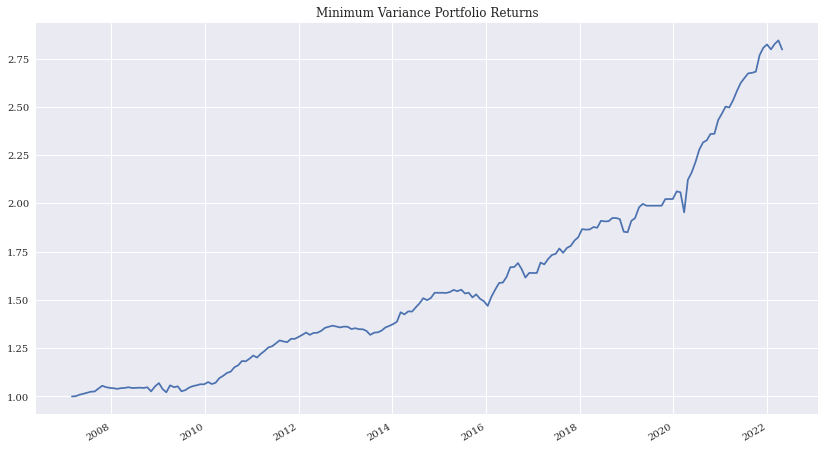

In [121]:
f.backtest_plot(prices_ts = df, weights_ts = weights_ts)

# VS S&P 500 Returns

<AxesSubplot:title={'center':'Minimum Variance Portfolio Returns'}, xlabel='Date'>

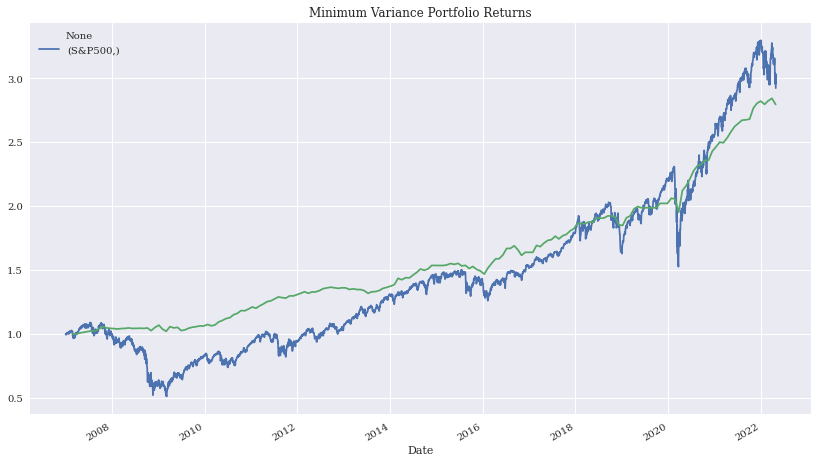

In [122]:
prices_ts = pd.DataFrame(df['S&P500'])
(1+((prices_ts-prices_ts.shift())/prices_ts.shift()).fillna(0)).cumprod().plot(figsize = (12,8))
f.backtest_plot(prices_ts = df, weights_ts = weights_ts)

# From the comparison between the Global Minimum Variance portfolio (Green) with the performance of the S&P500 (Blue), we can tell that it was significantly less volatile with lesser price swings. In 2008 the min vol strategy protected the portfolio fairly well, i.e it protected against the large drawdown from stock market crash. However, overall, the minimum variance portfolio still underperformed the S&P500 in terms of returns

# Extra Comments (Ignore)


## Cant be not invested in something
## Objective function to reduce turnover ratio and maximise (whichever metric)
## pyomo?

In [ ]:

def minimise_volatility(target_return, er, cov):
    '''
    Minimise volatility function will give a SINGLE array of weights for the assets
    for a given return value
    '''
    n = er.shape[0] #n would give the number of assets
    
    #Create a numpy array that repeats 1/n, n number of times
    # Put it into an initial guess where the weights are all equal
    initial_guess = np.repeat(1/n,n) 
    
    bounds = ((0.0,0.2),)*n  #Create a tuple of n number of tuples with 0 and 1 as the values within each tuple
    
    #Create our constraints which must be in a dictionary form
    return_is_target = {
        'type':"eq", #Equality type means that whatever formula is provided in the 'fun' line will be equal to zero
        'args': (er,), #arguments=> Over here it means that expected returns er is the variable argument
                       #and weights is the value we want
        'fun': lambda weights, er: target_return - portfolio_returns(weights, er)
    }
    weights_sum_to_1 = {
        'type':'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    
    max_asset_weight = {
        'type':'ineq',
        'fun':lambda weights: weights
    }
    
    weights_ = minimize(portfolio_variance, initial_guess,
                        #Note that the portfolio variance is another formula here(i.e this is a nested formula, with inputs 
                        #Covariance and weights, BUT we put the cov as an arg in the next line, ie. its a known variable)
                        args = (cov,), method = "SLSQP",
                        constraints = (return_is_target, weights_sum_to_1),
                        bounds = bounds)
    return weights_.x


def portfolio_variance(weights, covariance):
    '''
    To calculate the portfolio variance with the weights and covariance matrix
    We use the portfolio variance formula:
    Weights transpose -> Matrix multiply by covar matrix -> Matrix multiply by weights
    '''
    return (weights.T@ covariance @ weights)**0.5



def pf_returns(weights,df):
    rets = (df-df.shift(1))/df
    allocationWeights.columns = rets.columns
    rets = rets*allocationWeights.astype(float)
    return rets.sum(axis = 1)

def plot_backtest(weights,df):
    (1+pf_returns(weights, df)).cumprod().plot(figsize = (6,5))
    
def semideviation(r):
    semidev = r[r<0].std(ddof = 0)
    return semidev

def portfolio_returns(weights, returns):
    '''
    To calulate the returns from the weights of each asset.
    weights would be a numpy array which is then transposed to form a matrix
    returns is a series consisting of the returns(data) of different assets(index)
    Transpose weights - > Matrix multiplication with returns
    
    '''
    return weights.T @ returns


def resize_data(dataframe,rebal_freq = 5):
    Resizeddf = {}
    counter = 0
    for i in dataframe.index:
        counter +=1
        if counter ==rebal_freq:
            Resizeddf[i]=dataframe.loc[i]
            counter =0
    Resizeddata = pd.DataFrame(Resizeddf.values(), index = Resizeddf.keys(),
                               columns = dataframe.columns)        
    return Resizeddata    
    
    



<AxesSubplot:>

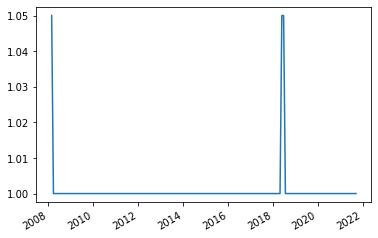

In [54]:
a = a.round(decimals = 10)
a.sum(axis =1).plot()

In [45]:
a.sum(axis = 1).index

DatetimeIndex(['2008-02-27', '2008-03-27', '2008-04-25', '2008-05-26',
               '2008-06-24', '2008-07-23', '2008-08-21', '2008-09-19',
               '2008-10-20', '2008-11-18',
               ...
               '2020-12-25', '2021-01-26', '2021-02-24', '2021-03-25',
               '2021-04-23', '2021-05-24', '2021-06-22', '2021-07-21',
               '2021-08-19', '2021-09-17'],
              dtype='datetime64[ns]', length=169, freq=None)

In [30]:
def momentumstrat(returns)    
    df = returns
    
    
    weights = df.ffill()
    weights = weights.dropna()
    weights = weights.round(5)
    weights = (weights.sub(weights.median(axis=1), axis=0) > 0 ) * 1
    
    weights = weights[(weights != weights.shift(1)).sum(axis=1) > 1]
    weights = weights.div(weights.sum(axis=1), axis=0)

    if verbose:
        print(weights.tail(20))
    weights = weights.dropna()

    return weights

SyntaxError: invalid syntax (<ipython-input-30-e4580e3b0e26>, line 1)

In [27]:
a = [1,2,3]
b = [4,2,5]
dictt = {}
for keyx in a:
    for valuey in b:
        dictt[keyx] = valuey
        b.remove(valuey)
        break

In [37]:
dictt[a[0]]

4

In [21]:
test_keys = ["Rash", "Kil", "Varsha"]
test_values = [1, 4, 5]
res = {}
for key in test_keys:
    for value in test_values:
        res[key] = value
        test_values.remove(value)
        break  

In [39]:
a = [1,2,3]
minht = min(a)

In [40]:
minht

1

In [41]:
a.remove(minht)
a

[2, 3]

In [43]:
a = [1,2,3,4]
xlabels = list(range(len(a)+1))
xlabels.remove(0)
xlabels

[1, 2, 3, 4]

In [52]:
height = [1,2,4]

In [53]:

def maxArea(self, height):
    arealist = []
    height2 = height
    xlabels = list(range(len(height)+1))
    xlabels.remove(0)
    while height:
        minheight = min(height)
        minhtidx = height2.index(minheight)
        for i in range(len(height2)):
            area = minheight * abs(xlabels[i]-xlabels[minhtidx])
            arealist.append(area)
            height.remove(minheight)


    return max(arealist)

In [54]:
maxArea(self = None, height = height)

ValueError: list.remove(x): x not in list

In [61]:
height = [1,2,4]
minheight = min(height)
height.remove(minheight)
height

[2, 4]

In [63]:
arealist = []
height2 = height
xlabels = list(range(len(height)+1))
xlabels.remove(0)
while height:
    minheight = min(height)
    minhtidx = height2.index(minheight)
    for i in range(len(height2)):
        area = minheight * abs(xlabels[i]-xlabels[minhtidx])
        arealist.append(area)
        height.remove(min(height))

In [68]:
height = [1,2,4]
arealist = []
height2 = height
xlabels = list(range(len(height)+1))
xlabels.remove(0)
while height:
    minhtidx = height2.index(min(height))
    for i in range(len(height2)):
        area = minheight * abs(xlabels[i]-xlabels[minhtidx])
        arealist.append(area)
        height.remove(min(height))



In [82]:
height = [1,2,4]
height.remove(4)

In [83]:
height

[1, 2]

In [79]:
min(height)

1

In [73]:
xlabels[2]

3

In [113]:
height = [1,2,4]
minht = min(height)
minhtidx = height.index(minht)
xlabels[minhtidx]

1

In [86]:
height = [1,8,6,2,5,4,8,3,7]
height2 = height.copy()


In [87]:
xlabels = list(range(len(height2)))
xlabels

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [88]:
minhtidx

1

In [89]:
xlabels[minhtidx]

1

In [90]:
height2

[1, 8, 6, 2, 5, 4, 8, 3, 7]

In [91]:
minhtidx

1

In [107]:
minheight

7

In [110]:
xlabels[minhtidx]

8

In [109]:
min(xlabels[minhtidx],xlabels[0])

0

In [111]:
minheight = min(height)
minhtidx = height2.index(minheight)
min(minheight,height2[0])* abs((xlabels[minhtidx]-xlabels[0]))

8

In [104]:
height.remove(min(height))

In [105]:
height

[8, 8, 7]

In [135]:
def maxArea(self, height):
    arealist = []
    xlabels = list(range(len(height)))

    height2 = height
    while height:
        for i in range(len(height2)):
            minheight = min(height)
            minhghtidx = height2.index(minheight)
            area = minheight * abs((xlabels[minhghtidx]-xlabels[i]))
            arealist.append(area)
            if i == (len(height)-1):
                height.remove(minheight)



    return arealist

In [34]:
height = [1,8,6,2,5,181,4,8,3,7,2912,182]


In [3]:

def maxArea(self, height):
    arealist = []
    height2 = []
    height2[:] = height[:] #make a height 2 as I am going to slowly remove the minimum values from the height list
    xlabels = list(range(len(height2)))
    height = height
    while height:
        for i in range(len(height2)):
            minheight = min(height)
            minhghtidx = height2.index(minheight)

            area = min(minheight,height2[i]) * abs((xlabels[minhghtidx]-xlabels[i])) #Take the minimum of the minheight and height of the other point
            arealist.append(area) #Append all areas to the arealist
            if i == len(height2)-1:

                height.remove(min(height))



    return max(arealist)

In [35]:
maxArea( height = height)

1086

In [27]:
def maxProfit(prices):
        while True:
            if prices.index(max(prices))== len(prices)-1:
                prices.remove(max(prices))
            elif prices.index(min(prices)) == 0:
                prices.remove(min(prices))
            elif prices.index(min(prices))<prices.index(max(prices)):
                profit = max(prices)-min
                return profit
            elif prices.index(min(prices))>prices.index(max(prices)):
                prices.remove(min(prices))
            elif len(prices) <2:
                return profit
            else: continue
                     

In [33]:
p = [7,1,5,3,6,4]


In [36]:
def maxProfit(prices):
    n = len(prices)
    if len(prices)<2:
        return 0
    maxprofit = 0
    minpx = prices[0]
    for px in prices:
        maxprofit = max(px-minpx,maxprofit)
        minpx = min(minpx,px)
    return maxprofit
    
    

In [37]:
maxProfit(p)

5